# Flow based models

## General

Papers:

1. L Baird, D Smalenberger, and S Ingkiriwang "One-Step Neural Network Inversion with PDF Learning and Emulation" (2005).
2. L Dinh, D Krueger, Y Bengio "NICE: Non-Linaer Independent Components Estimation" (2015).
3. L Dinh, J Sohl-Dickstein, and S Bengio "Density Estimation Using Real NVP" (2016).

See also [this blog post](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html).

Assume a multi-step transformation of a random variable:

$$
\begin{aligned}
    y_ 0 &\sim P_0(y_0) \\
    y_{n} &= g_n(y_{n - 1}) \\
\end{aligned}
$$

According to the change of [variable formula for probability densities](https://en.wikipedia.org/wiki/Probability_density_function):

$$
\begin{aligned}
    \log P_n(y_n) 
        &= \log P_{n - 1}(y_{n - 1}) + \log \left| 
            \det \frac{\mathrm{d}y_{n - 1}(y_n)}{\mathrm{d} y_n} 
        \right| \\
        &= \log P_{n - 1}(y_{n - 1}) - \log \left| 
            \det \left( \frac{\mathrm{d}g_n(y)}{\mathrm{d} y}  \right)_{y = y_{n - 1}}
        \right| \\
        &= P_0(y_0) - \sum_{k=1}^{n} \log \left| 
            \det \left( \frac{\mathrm{d}g_k(y)}{\mathrm{d} y}  \right)_{y = y_{k - 1}}
        \right|
\end{aligned}
$$

# Connection to Autoencoders

Identify $z := y_0$ and $x := y_n$, then $g = g_n \circ g_{n - 1} \dots g_1$ is the decoder and $f = g^{-1}$ the encoder.

### Additive Coupling Layers

As proosed in (Dinh, Krueger, Bengio, 2015):

Split input tensor $y_{n - 1}$ into two subsets $y_{n - 1, I_1},  y_{n - 1, I_2}$, where the index sets $I_1$, $I_2$ are nonoverlapping. The transformation is composed as:

$$
\begin{aligned}
    y_{n, I_1} &= y_{n - 1, I_1}, \\
    y_{n, I_1} &= y_{n - 1, I_2} + m(y_{n - 1, I_1}), \\
\end{aligned}
$$

with $m$ being arbitrary. The Jacobian is $\left| \frac{\mathrm{d}y_n}{\mathrm{d}y_{n-1}}\right| = 1$. To mix all components at least three coupling layers need to be stacked on top of each other with the index sets swapped between each layer. 

To allow volume changes the coupling layer needs to be combined with an additional scaling layer.

## Scaling Layer

As proposed in (Dinh, Krueger, Bengio, 2015). The transformation reads:

$$
\begin{aligned}
    y_{n,i} &= s_i y_{n-1,i} \\
\end{aligned}
$$

With the Jacobian $\left| \frac{\mathrm{d}y_n}{\mathrm{d}y_{n-1}}\right| = \prod_i |s_i|$

## Affine Coupling Layer

As proposed by (Dinh, Sohl-Dickstein, Bengio, 2016).

$$
\begin{aligned}
    y_{n, I_1} &= y_{n - 1, I_1}, \\
    y_{n, I_1} &= y_{n - 1, I_2} \odot \exp\left[s(y_{n - 1, I_1}) \right] + t(y_{n - 1, I_1}), \\
\end{aligned}
$$

With the log Jacobian:

$$
    \log \left| \frac{\mathrm{d}y_n}{\mathrm{d}y_{n-1}}\right| = \sum_i s_i(y_{n-1, I_1})
$$


In [27]:
%matplotlib inline

import functools as ft

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.interpolate
import sklearn.datasets
import torch

import ttensor

from chmp.ds import reload
reload('chmp.ds')
from chmp.ds import mpl_axis, colormap, colorize, plot_gaussian_contour, get_color_cycle, Loop, smap
from chmp.torch_utils import t2n, n2t, call_torch, NumpyDataset

1 One-Step Neural Network Inversion with PDF Learning and Emulation

$$
\begin{aligned}
    f_c(x) &= \mathrm{arcsinh}(c + \sinh(x)) \\
    \frac{\mathrm{d}}{\mathrm{d}x} f_c(x) &= \frac{\cosh(x) }{\sqrt{(c + \sinh(x)) ^2 + 1}} \\
\end{aligned}
$$

$$
\begin{aligned}
    \sinh(x) &= \frac{1}{2} \left( e^x - e^{-x} \right)
    &
    \frac{\mathrm{d}}{\mathrm{d} x} \sinh(x) &= \cosh(x) \\
    \mathrm{arcsinh}(x) &= \ln\left(x + \sqrt{x^2 + 1} \right) 
    &
    \frac{\mathrm{d}}{\mathrm{d} x} \mathrm{arcsinh}(x) &= \frac{1}{\sqrt{x^2 + 1}} \\
\end{aligned}
$$

In [2]:
f_activation = lambda x, c: np.arcsinh(c + np.sinh(x))
df_activation = lambda x, c: np.cosh(x) / np.sqrt((c + np.sinh(x)) ** 2.0 + 1)

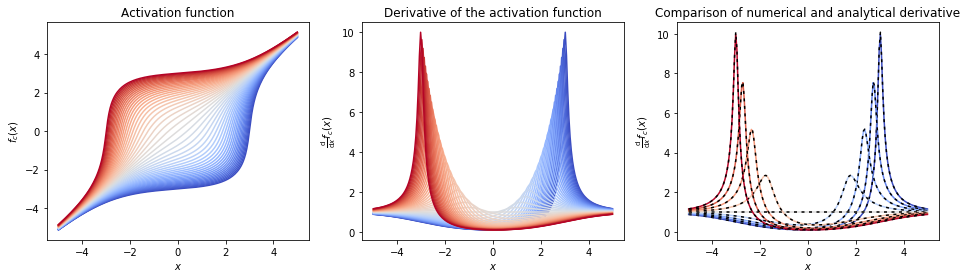

In [3]:
u = np.linspace(-5, 5, 200)
cu = 0.5 * (u[1:] + u[:-1])

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

with mpl_axis(
    ax1, 
    title="Activation function", 
    xlabel=r"$x$", 
    ylabel=r"$f_c(x)$",
):
    for c, b in colorize(np.linspace(-10.0, 10.0, 51), cmap="coolwarm"):
        plt.plot(u, f_activation(u, b), color=c)
        
with mpl_axis(
    ax2,
    title="Derivative of the activation function", 
    xlabel=r"$x$", 
    ylabel=r"$\frac{\mathrm{d}}{\mathrm{d}x} f_c(x)$",
):  
    for c, b in colorize(np.linspace(-10.0, 10.0, 51), cmap="coolwarm"):
        plt.plot(cu, np.diff(f_activation(u, b)) / np.diff(u), color=c)
        
        
with mpl_axis(
    ax3,
    title='Comparison of numerical and analytical derivative',
    xlabel=r"$x$", 
    ylabel=r"$\frac{\mathrm{d}}{\mathrm{d}x} f_c(x)$",
):
    for c, b in colorize(np.linspace(-10.0, 10.0, 9), cmap="coolwarm"):    
        plt.plot(cu, np.diff(f_activation(u, b)) / np.diff(u), color=c)
        plt.plot(cu, df_activation(cu, b), '--', color='k', dashes=(2, 3))

In [4]:
x = np.random.normal(size=(50_000, 2))
w = np.asarray([
    [3.0, +0.5],
    [+0.5, +0.5]
])
c = 4

y_1 = x @ w
y = np.arcsinh(c + np.sinh(y_1))

In [5]:
p_base = scipy.stats.norm(0, 1)

In [6]:
u = np.linspace(-7, +7, 100)

In [7]:
logpdf = (
    p_base.logpdf(x[:, 0]) 
    + p_base.logpdf(x[:, 1])
    - np.log(np.abs(np.linalg.det(w)))
    - np.log(np.abs(df_activation(y_1[:, 0], c)))
    - np.log(np.abs(df_activation(y_1[:, 1], c)))
)

In [8]:
grid_y0 = np.linspace(-7, +7, 41)
grid_y1 = np.linspace(0, 3, 31)
grid_y0, grid_y1 = np.meshgrid(grid_y0, grid_y1)


In [9]:
gridded = scipy.interpolate.griddata(y, logpdf, (grid_y0, grid_y1), method='cubic')

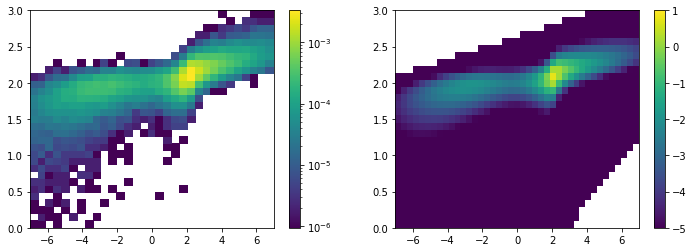

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

with mpl_axis(ax1, colorbar=True):
    plt.hist2d(
        y[:, 0], y[:, 1], 
        range=((-7, +7), (0, +3)), 
        bins=(31, 31), 
        norm=mpl.colors.LogNorm(),
        weights=np.ones_like(y[:, 0]) * (14 / 30) * (3 / 30) * (1 / len(y)),
    )

with mpl_axis(ax2, colorbar=True):
    plt.imshow(gridded, origin='lower', aspect='auto', extent=(-7, +7, 0, +3), vmax=1, vmin=-5)

In [11]:
class FlowDensityModel(torch.nn.Module):
    def __init__(self, *flow):
        super().__init__()
        
        if len(flow) == 0:
            raise TypeError()
        
        elif len(flow) == 1:
            flow,  = flow
            
        else:
            flow = torch.nn.Sequential(*flow)
        
        self.flow = flow
    
    def forward(self, arg):
        if not isinstance(arg, tuple):
            arg = (
                arg, 
                torch.zeros(arg.shape[:-1], dtype=arg.dtype, device=arg.device),
            )
        
        return self.flow(arg)
        
    def transform(self, arg):
        res, _ = self.forward(arg)
        return res
        
    def compute_loss(self, x, yp, yt):
        image, d_log_p = yp
        
        p_base = torch.distributions.Normal(
            loc=torch.zeros_like(image),
            scale=torch.ones_like(image),
        )
        base_log_p = p_base.log_prob(image).sum(dim=-1)
        
        # TODO: change convention. why subtract?
        log_p = base_log_p - d_log_p
        return -torch.mean(log_p)


class FlowLinear(torch.nn.Module):
    """A linear layer as part of a flow based transformation"""
    def __init__(self, in_features, out_features, bias=True, forward=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.forward_ = forward
        
        self.weight = torch.nn.Parameter(torch.empty(in_features, out_features))
        torch.nn.init.xavier_normal_(self.weight)
        
        if bias is True:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
        else:
            self.bias = None
    
    def forward(self, arg):
        return flow_linear(arg, self.weight, self.bias, self.forward_)
    
    def extra_repr(self):
        return ', '.join([
            f'in_features={self.in_features}', 
            f'out_features={self.out_features}',
            f'bias={self.bias is not None}',
        ])
        
        
class FlowHyperbolic(torch.nn.Module):
    def __init__(self, features, forward=True):
        super().__init__()
        self.offset = torch.nn.Parameter(torch.zeros(features))
        self.forward_ = forward
    
    def forward(self, arg):
        return flow_hyperbolic(arg, self.offset, self.forward_)
        
        
class FlowSinhArcsinh(torch.nn.Module):
    def __init__(self, features, forward=True):
        super().__init__()
        self.offset = torch.nn.Parameter(torch.zeros(features))
        self.forward_ = forward
    
    def forward(self, arg):
        return flow_sinh_arcsinh(arg, self.offset)
        
        
class FlowSoftplus(torch.nn.Module):
    def forward(self, arg):
        return flow_softplus(arg)
        
        
def flow_linear(arg, weight, bias, forward=True):
    tt = ttensor.backend(weight, bias)
    
    # TODO: write with tt
    x, log_px = arg
    
    # NOTE: the weights are the same for each batch element
    delta_log_px = tt.log(abs(tt.linalg.det(weight)))
    delta_log_px = tt.broadcast_to(delta_log_px, tt.shape(x)[:-1])
    
    if bias is None:
        return x @ weight, log_px - delta_log_px
    
    return bias + x @ weight, log_px - delta_log_px


def flow_hyperbolic(arg, offset, forward=True):
    x, log_px = arg
    
    tt = ttensor.backend(x, log_px)
    
    # stabilized version adapted from 
    #   L Baird, D Smalenberger, and S Ingkiriwang 
    #   "One-Step Neural Network Inversion with PDF Learning and Emulation" (2005).
    t = 0.5 - 0.5 * tt.exp(-2 * abs(x)) + tt.sign(x) * offset * tt.exp(-abs(x))
    res = x + tt.sign(x) * tt.log(t + tt.sqrt(tt.exp(-2 * abs(x)) + t ** 2.0))
    
    jac = tt.log(tt.cosh(x)) - 0.5 * tt.log(1.0 + (offset + tt.sinh(x)) ** 2.0)
    jac = tt.sum(jac, axis=-1)
    
    delta_log_p_sign = +1 if forward else -1
    return res, log_px - delta_log_p_sign * jac


def flow_sinh_arcsinh(arg, offset):
    x, log_px = arg
    
    tt = ttensor.backend(x, log_px)
    
    dx = -tt.sinh(offset)
    res = tt.sinh(offset + tt.arcsinh(x + dx))
    
    jac = tt.log(tt.cosh(offset + tt.arcsinh(x + dx))) - 0.5 * tt.log(1 + (x + dx) ** 2.0)
    jac = tt.sum(jac, axis=-1)
    
    return res, log_px - jac


def flow_softplus(arg):
    x, log_px = arg
    
    tt = ttensor.backend(x, log_px)
    
    res = tt.softplus(x)
    jac = tt.sum(abs(tt.softplus(-x)), axis=-1)
    
    return res, log_px - jac

In [12]:
tt = ttensor.backend('torch')

In [15]:
@ft.singledispatch
def invert_module(m):
    """Invert a flow network.
    
    :param m:
        any ``torch.nn.Module`` that is invertible.
    """
    raise NotImplementedError(f"Cannot invert {type(m).__name__}")
    
    
@invert_module.register(torch.nn.Sequential)
def invert_sequential_flow(m):
    parts = [invert_module(c) for c in m]
    parts.reverse()
    return torch.nn.Sequential(*parts)


@invert_module.register(FlowLinear)
def invert_linear_flow(m):
    assert m.in_features == m.out_features
        
    r = FlowLinear(
        m.out_features, 
        m.in_features, 
        bias=m.bias is not None, 
        forward=not m.forward_
    )
    
    with torch.no_grad():
        r.weight.copy_(torch.inverse(m.weight))
        
        if m.bias is not None:
            r.bias.copy_(-m.bias @ r.weight)
        
    return r


@invert_module.register(FlowHyperbolic)
def invert_hyperbolic_flow(m):
    r = FlowHyperbolic(m.offset.shape[0], forward=not m.forward_)
    
    with torch.no_grad():
        r.offset.copy_(-m.offset)
    
    return r

In [16]:
B = 20

# flow = FlowHyperbolic(2)
# flow = FlowLinear(2, 2)
flow = torch.nn.Sequential(FlowLinear(2, 2), FlowHyperbolic(2), FlowLinear(2, 2), FlowHyperbolic(2))
inverse_flow = invert_module(flow)

p_base = torch.distributions.Normal(torch.zeros(B, 2), torch.ones(B, 2))

x0 = p_base.rsample()
p0 = p_base.log_prob(x0).sum(dim=1)

with torch.no_grad():
    xf, pf = flow((x0, p0))
    xi, pi = inverse_flow((xf, pf))

In [17]:
print(xi[0], x0[0])
print(pi[:2], p0[:2])

tensor([ 0.0513, -0.5889]) tensor([ 0.0513, -0.5889])
tensor([-2.0126, -2.2250]) tensor([-2.0126, -2.2250])


In [20]:
rotation = np.rad2deg(30)
rotation = np.asarray([
    [+np.cos(rotation), -np.sin(rotation)],
    [+np.sin(rotation), +np.cos(rotation)]
])

transform = np.diag([2, 1]) @ rotation

x = np.random.normal(size=(1_000, 2))
y = np.asarray([[1, 1]]) + x @ transform

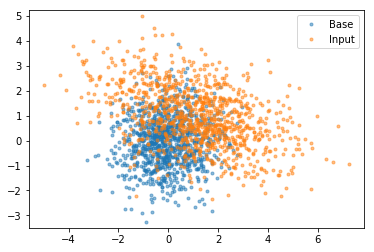

In [21]:
with mpl_axis(axis='equal', legend=True):
    plt.plot(x[:, 0], x[:, 1], '.', label='Base', alpha=0.5)
    plt.plot(y[:, 0], y[:, 1], '.', label='Input', alpha=0.5)

In [22]:
def make_train_func(*, model, optimizer, criterion=None, device=None):
    def train_func(engine, batch):
        batch = smap(lambda x: x.to(device), batch)
        x, yt = batch if isinstance(batch, tuple) else (batch, None)
        
        optimizer.zero_grad()
        yp = model(x)
        
        if criterion is None:
            loss = model.compute_loss(x, yp, yt)
        
        else:
            loss = criterion(yp, yt)

        loss.backward()
        optimizer.step()
        return float(loss)
    
    return train_func

In [28]:
model = FlowDensityModel(FlowLinear(2, 2))
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
train_func = make_train_func(model=model, optimizer=optimizer)

dataset = NumpyDataset(y, dtype='float32')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)

losses = []
loop = Loop()

for _ in loop.nest(range(10)):
    for batch in loop.nest(dataloader):
        loss = train_func(None, batch)
        losses += [loss]
        
        loop.print(lambda: f'{loop} {loss:.2g}')

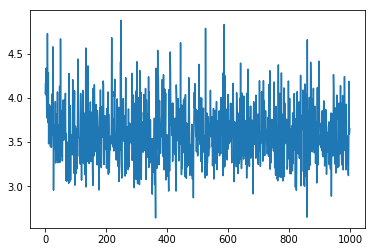

In [29]:
plt.plot(losses)

In [30]:
image = call_torch(model.transform, (y, np.zeros(len(y))), dtype=torch.float32)

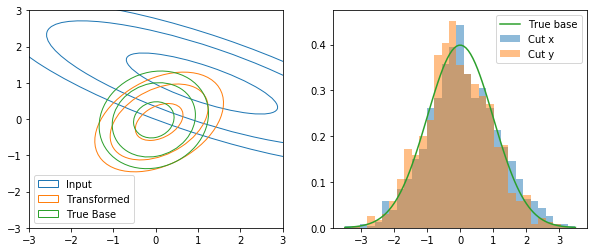

In [31]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
c0, c1, c2 = get_color_cycle(3)

with mpl_axis(ax1, xlim=(-3, +3), ylim=(-3, +3)):
    q = (0.99, 0.95, 0.66)
    a0 = plot_gaussian_contour(y[:, 0], y[:, 1], q=q, edgecolor=c0)
    a1 = plot_gaussian_contour(image[:, 0], image[:, 1], q=q, edgecolor=c1)
    a2 = plot_gaussian_contour(x[:, 0], x[:, 1], q=q, edgecolor=c2)
    
    plt.legend([a0, a1, a2], ['Input', 'Transformed', 'True Base'], loc='lower left')
    
with mpl_axis(ax2, legend=True):
    u = np.linspace(-3.5, 3.5, 100)
    p = scipy.stats.norm(0, 1).pdf(u)

    plt.hist(
        image[:, 0], 
        density=True, bins=31, range=(u.min(), u.max()), alpha=0.5, label='Cut x', color=c0,
    )
    plt.hist(
        image[:, 1], 
        density=True, bins=31, range=(u.min(), u.max()), alpha=0.5, label='Cut y', color=c1,
    )
    plt.plot(u, p, label='True base', color=c2)

# S Data

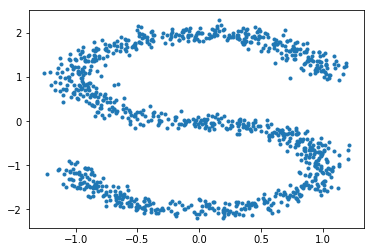

In [32]:
y, _ = sklearn.datasets.make_s_curve(n_samples=1_000, noise=0.1, random_state=42)
y = y[:, [0, 2]]

plt.plot(y[:, 0], y[:, 1], '.')

In [33]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, *coupling):
        super().__init__()
        self.coupling = torch.nn.Sequential(*coupling)
        
    def forward(self, arg):
        x, log_p = arg
        n = x.shape[-1] // 2
        
        return (
            torch.cat([x[..., :n], x[..., n:] + self.coupling(x[..., :n])], dim=-1),
            log_p,
        )
    
    
class Permute(torch.nn.Module):
    def forward(self, arg):
        x, log_p = arg
        n = x.shape[-1] // 2
        return torch.cat([x[..., n:], x[..., :n]], dim=-1), log_p

In [34]:
model = FlowDensityModel(
    #
    #FlowSinhArcsinh(2),
    #FlowLinear(2, 2),
    #FlowSinhArcsinh(2),
    #FlowLinear(2, 2),
    #FlowSinhArcsinh(2),
    #FlowLinear(2, 2),
    #FlowSinhArcsinh(2),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
    FlowLinear(2, 2), 
    AffineCoupling(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_func = make_train_func(model=model, optimizer=optimizer)

dataset = NumpyDataset(y, dtype='float32')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)

losses = []
loop = Loop()

for _ in loop.nest(range(100)):
    for batch in loop.nest(dataloader):
        loss = train_func(None, batch)
        losses += [loss]
        
        loop.print(lambda: f'{loop} {loss:.2g}')

In [35]:
image = call_torch(model.transform, y, dtype=torch.float32)

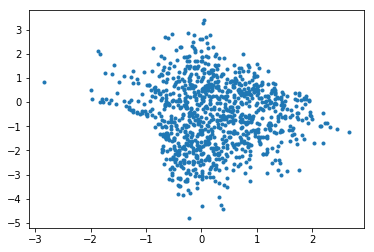

In [36]:
plt.plot(image[:, 0], image[:, 1], '.')